# Part 1

## Installing BioPython

BioPython is a useful package for processing FASTA files containing DNA/protein sequences. The following commands can be used to install biopython, which we will use throughout this project.

In [ ]:
try:
  import google.colab
  !pip install biopython
except ImportError:
  pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.8 MB/s eta 0:00:00


## Loading in FASTA files

FASTA files can be read using biopython. A function can be defined to read a FASTA file containing a single sequence, returning the sequence contained in the file.

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq

def read_fasta(file_name):
  # read FASTA file
  seq = SeqIO.parse(open(file_name),'fasta')

  # get cDNA sequence from FASTA file
  for record in seq:
    example = record
    break

  seq = Seq(example.seq)
  return seq


## Part 1 sequence

We can then use the previously defined function to read the sequence from part 1 from its FASTA file, titled 'part1_sequence.fasta'. The sequence contained in this file is printed below, along with the number of bases in this sequence.

In [ ]:
seq_1 = read_fasta("part1_sequence.fasta")
print("Sequence:", seq_1)
print("Length:", len(seq_1))

Sequence: ATTGCCATGACGGATCAGCCGCAAGCGGAATTGGCGTTTACGTACGGATGCGCCGTAATATAGGCCATAGAC
Length: 72


## Finding the longest ORF in each frame

Our aim is now to find the longest ORF in each frame of a given sequence. For a given DNA sequence, there are typically 6 different frames: 3 frames on the forward strand, and 3 frames on the reverse-complement strand. We will first need to define a function to give the reverse complement sequence for any given DNA sequence.

In [ ]:
def reverse_complement(sequence):
  base_pairing = {"A": "T", "T": "A", "G": "C", "C": "G"}
  reverse = []
  for i in range(len(sequence) - 1, -1, -1):
    reverse.append(base_pairing[sequence[i]])

  return "".join(reverse)

reverse_complement(seq_1)

'GTCTATGGCCTATATTACGGCGCATCCGTACGTAAACGCCAATTCCGCTTGCGGCTGATCCGTCATGGCAAT'

We can now define a function to find the longest ORF in each of the 6 potential reading frames.

In [ ]:
def find_ORF(sequence): # takes string of bases as an argument
  ORFs = []
  for i in range(3): # iterating through all frames
    forward_seq = sequence[i:]
    forward_seq = forward_seq[: len(forward_seq) - len(forward_seq)%3] # remove 'remainder' bases so that they are not included at start of compliment strand (next line)
    reverse_seq = Seq(reverse_complement(forward_seq))

    for seq in [forward_seq, reverse_seq]: # for both sequences
      stops = []
      starts = []

      for j in range(0, len(seq), 3): # check every 3 bases
        if seq[j:j+3] == "ATG": # find all possible start codons
          starts.append(j)
        elif seq[j:j+3] in ["TAA", "TAG", "TGA"]: # find all possible stop codons
          stops.append(j)

      # now find the longest distance between any start codon and its nearest (downstream) stop codon
      max_length = 0
      start_stop = []
      for start in starts: # check each start position
        stops_copy = stops # to preserve original list
        stops_copy = [stop for stop in stops_copy if stop > start] # ignore any upstream stop codons
        if stops_copy and (min(stops_copy) - start > max_length):
          start_stop = [start, min(stops_copy)]
          max_length = min(stops_copy) - start

      if max_length: # True if max_length != 0
        ORFs.append([seq, start_stop[0], start_stop[1]]) # [sequence, position of start codon, position of stop codon]

  return ORFs # returns a maximum of 6 ORFs

find_ORF(seq_1) # test on part 1 sequence

[[Seq('ATTGCCATGACGGATCAGCCGCAAGCGGAATTGGCGTTTACGTACGGATGCGCC...GAC'), 6, 60],
 [Seq('TCTATGGCCTATATTACGGCGCATCCGTACGTAAACGCCAATTCCGCTTGCGGC...GCA'), 3, 54]]

## The ORFs of a sequence can be translated
For convenience, this can be made into a function called display_sequences()

In [ ]:
def display_sequences(sequence):
  ORFs = find_ORF(sequence)
  for i in range(len(ORFs)):
    start = ORFs[i][1]
    stop = ORFs[i][2]
    seq = ORFs[i][0][start:stop]
    print("ORF {}:".format(i+1))
    print("Nucleotide sequence", seq)
    print("Nucleotide count:", len(seq))
    print("Amino acid sequence", seq.translate())
    print("Amino acid count:", len(seq.translate()))
    print("\n")

display_sequences(seq_1)

ORF 1:
Nucleotide sequence ATGACGGATCAGCCGCAAGCGGAATTGGCGTTTACGTACGGATGCGCCGTAATA
Nucleotide count: 54
Amino acid sequence MTDQPQAELAFTYGCAVI
Amino acid count: 18


ORF 2:
Nucleotide sequence ATGGCCTATATTACGGCGCATCCGTACGTAAACGCCAATTCCGCTTGCGGC
Nucleotide count: 51
Amino acid sequence MAYITAHPYVNANSACG
Amino acid count: 17




## Using the longest ORF

Typically, we look for the longest ORF in a given sequence, as this is most likely to correspond to a protein. A function can be created to take the output of the 'find_ORF' function and return the amino acid sequence corresponding to the longest ORF.


In [ ]:
def get_longest(ORFs):
  longest = 0
  sequence = None
  for i in range(len(ORFs)):
    start = ORFs[i][1]
    stop = ORFs[i][2]
    seq = ORFs[i][0][start:stop]
    if len(seq) > longest:
      longest = len(seq)
      sequence = seq

  return Seq(sequence).translate() # returns the amino acid sequence corresponding to the longest ORF

print(get_longest(find_ORF(seq_1)))

MTDQPQAELAFTYGCAVI


## This can be stored as a FASTA file

This sequence can be stored as a FASTA file so that it can be interrogated using the BLAST algorithm. For convenience, a function can be defined so that it may be used later.

In [ ]:
aa_seq_1 = get_longest(find_ORF(seq_1))

def write_fasta(title, seq, file_name):
  fasta_seq = title + "\n" + str(seq) + "\n"
  with open(file_name, 'w') as f:
    f.write(fasta_seq)

write_fasta(">part1_amino_acid_sequence", aa_seq_1, "part_1.fasta")

This file should now appear on the left hand side of the notebook in the Files section. The file should have the title "part_1.fasta".

## Test code on human BRCA2 gene
The BRCA2 DNA sequence can be downloaded from:

https://www.ensembl.org/Homo_sapiens/Transcript/Sequence_cDNA?db=core;g=ENSG00000139618;r=13:32315086-32400268;t=ENST00000380152

The ORFs of this sequence can be displayed as shown previously.

In [ ]:
BRCA2 = read_fasta("BRCA2_codingsequences.fa")

display_sequences(BRCA2)

ORF 1:
Nucleotide sequence ATGCCTATTGGATCCAAAGAGAGGCCAACATTTTTTGAAATTTTTAAGACACGCTGCAACAAAGCAGATTTAGGACCAATAAGTCTTAATTGGTTTGAAGAACTTTCTTCAGAAGCTCCACCCTATAATTCTGAACCTGCAGAAGAATCTGAACATAAAAACAACAATTACGAACCAAACCTATTTAAAACTCCACAAAGGAAACCATCTTATAATCAGCTGGCTTCAACTCCAATAATATTCAAAGAGCAAGGGCTGACTCTGCCGCTGTACCAATCTCCTGTAAAAGAATTAGATAAATTCAAATTAGACTTAGGAAGGAATGTTCCCAATAGTAGACATAAAAGTCTTCGCACAGTGAAAACTAAAATGGATCAAGCAGATGATGTTTCCTGTCCACTTCTAAATTCTTGTCTTAGTGAAAGTCCTGTTGTTCTACAATGTACACATGTAACACCACAAAGAGATAAGTCAGTGGTATGTGGGAGTTTGTTTCATACACCAAAGTTTGTGAAGGGTCGTCAGACACCAAAACATATTTCTGAAAGTCTAGGAGCTGAGGTGGATCCTGATATGTCTTGGTCAAGTTCTTTAGCTACACCACCCACCCTTAGTTCTACTGTGCTCATAGTCAGAAATGAAGAAGCATCTGAAACTGTATTTCCTCATGATACTACTGCTAATGTGAAAAGCTATTTTTCCAATCATGATGAAAGTCTGAAGAAAAATGATAGATTTATCGCTTCTGTGACAGACAGTGAAAACACAAATCAAAGAGAAGCTGCAAGTCATGGATTTGGAAAAACATCAGGGAATTCATTTAAAGTAAATAGCTGCAAAGACCACATTGGAAAGTCAATGCCAAATGTCCTAGAAGATGAAGTATATGAAACAGTTGTAGATACCTCTGAAGAAGATAGTTTTTCATTATGTTTTTCTAAATGTAGAACAAAAAATCTACAAAAAGTAAGAA

The longest ORF found from this sequence (starting with 'MPIGSK...') is the same as the amino acid sequence stated on the NCBI website. This suggests that the code is working.

# Part 2

The first Dinosaur DNA sequence, taken from the Jurassic Park novel, can be read, and the ORFs displayed.

In [ ]:
dino = read_fasta("part2_Dinosaur_DNA.fasta")

display_sequences(dino)


ORF 1:
Nucleotide sequence ATGCCGCACATGGACGCGTTGCTGGCGTTTTTCCATAGGCTCCGCCCCCCTGACGAGCATCACAAACAAGTCAGAGGTGGCGAAACCCGACAGGACTATAAAGATACCAGGCGTTTCCCCCTGGAAGCGCTCTCCTGTTCCGACCCTGCCGCTTACCGGATACCTGTCCGCCTTTCTCCCTTCGGGCTTTCTCAATGCTCACGCTGTAGGTATCTCAGTTCGGTG
Nucleotide count: 225
Amino acid sequence MPHMDALLAFFHRLRPPDEHHKQVRGGETRQDYKDTRRFPLEALSCSDPAAYRIPVRLSPFGLSQCSRCRYLSSV
Amino acid count: 75


ORF 2:
Nucleotide sequence ATGACCCAGAGCGCTGCCGGCACCTGTCCTACTTTACCGGGTTGGACTCAAGACGATAGTTACCGGATAAGGCGCAGCGGTCGGGCTGAACGGCACACAGCCCAGCTTGGAGCGAACGACCTACACCGAACTGAGATAGGTACAGCG
Nucleotide count: 147
Amino acid sequence MTQSAAGTCPTLPGWTQDDSYRIRRSGRAERHTAQLGANDLHRTEIGTA
Amino acid count: 49


ORF 3:
Nucleotide sequence ATGACGACCATCAGGGACAGCTTCAACGGCTCTTACCAGCCTAACTTCGATCACTGGACCGCTGATCGTCACGGCGATTTATGCCGCACATGGACGCGTTGCTGGCGTTTTTCCATAGGCTCCGCCCCCCTGACGAGCATCACAAACAAGTCAGAGGTGGCGAAACCCGACAGGACTATAAAGATACCAGGCGTTTCCCCCTGGAAGCGCTCTCCTGTTCCGACCCTGCCGCTTACCGGATACCTGTCCGCCTTTCTCCCTTCGGGCTTTCTCAATGCTCACGCTGTAG

The longest ORF is then saved into a FASTA file.

In [ ]:
dino_aa = get_longest(find_ORF(dino))

write_fasta(">Dinosaur_DNA", dino_aa, "Dino_amino_acids.fasta")

After running this amino acid sequence through the BLAST algorithm, it appears that the sequence is most related to an unnamed human protein. The next most related sequences belong to a variety of bacteria. This results seems unlikely as humans (Homo sapiens) are not closely related to Dinosaurs. Bacteria are even less closely related to Dinosaurs.

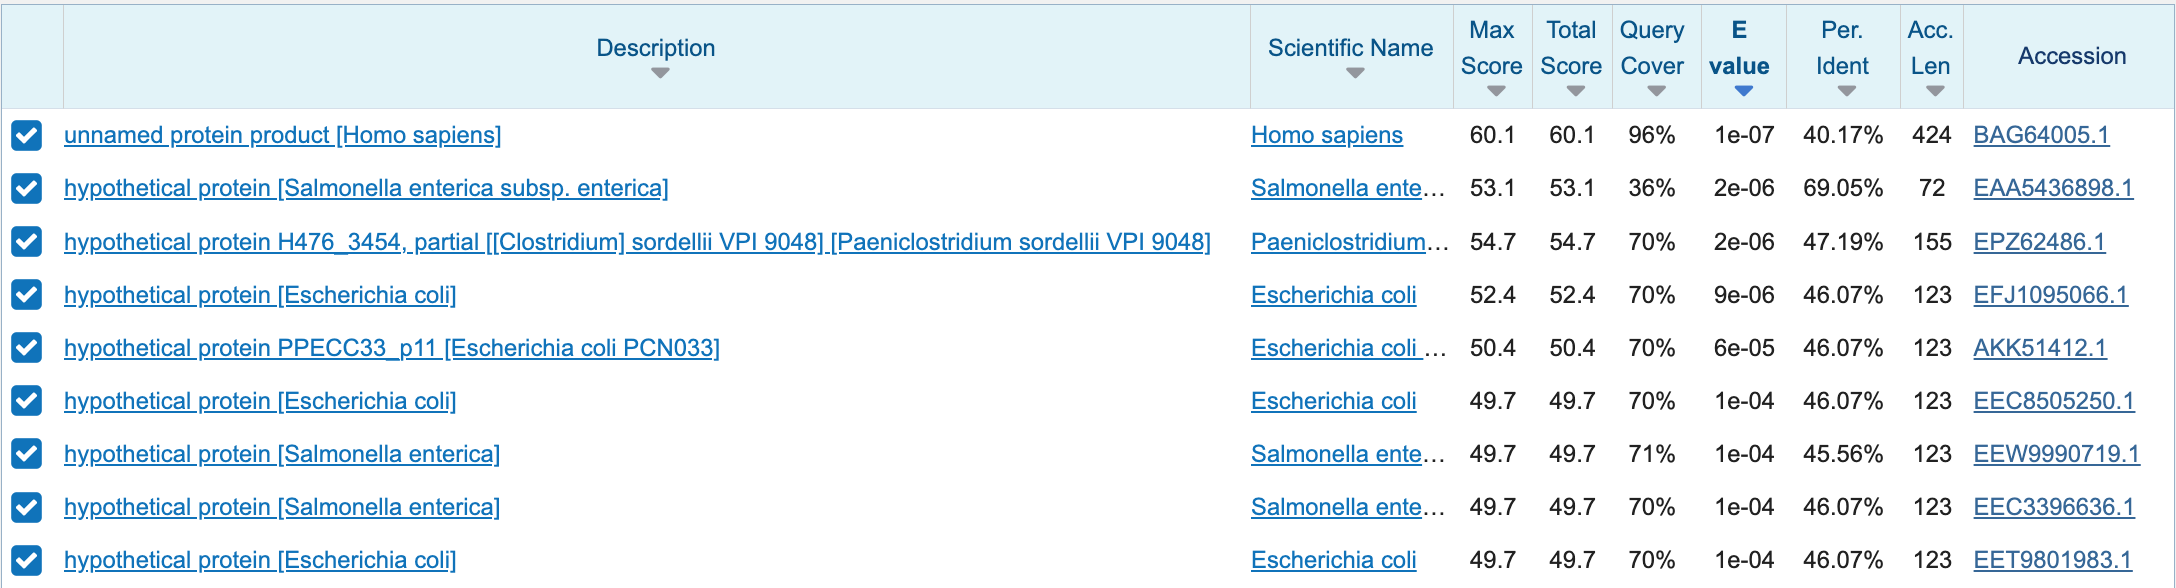

Running BLAST on amino acid sequences from other frames of this DNA sequence also returns protein sequences from various bacteria. This suggests that it is likely that the sequence is fictitious.

To confirm this results, the original DNA sequence from the novel can be ran through the BLAST algorithm.

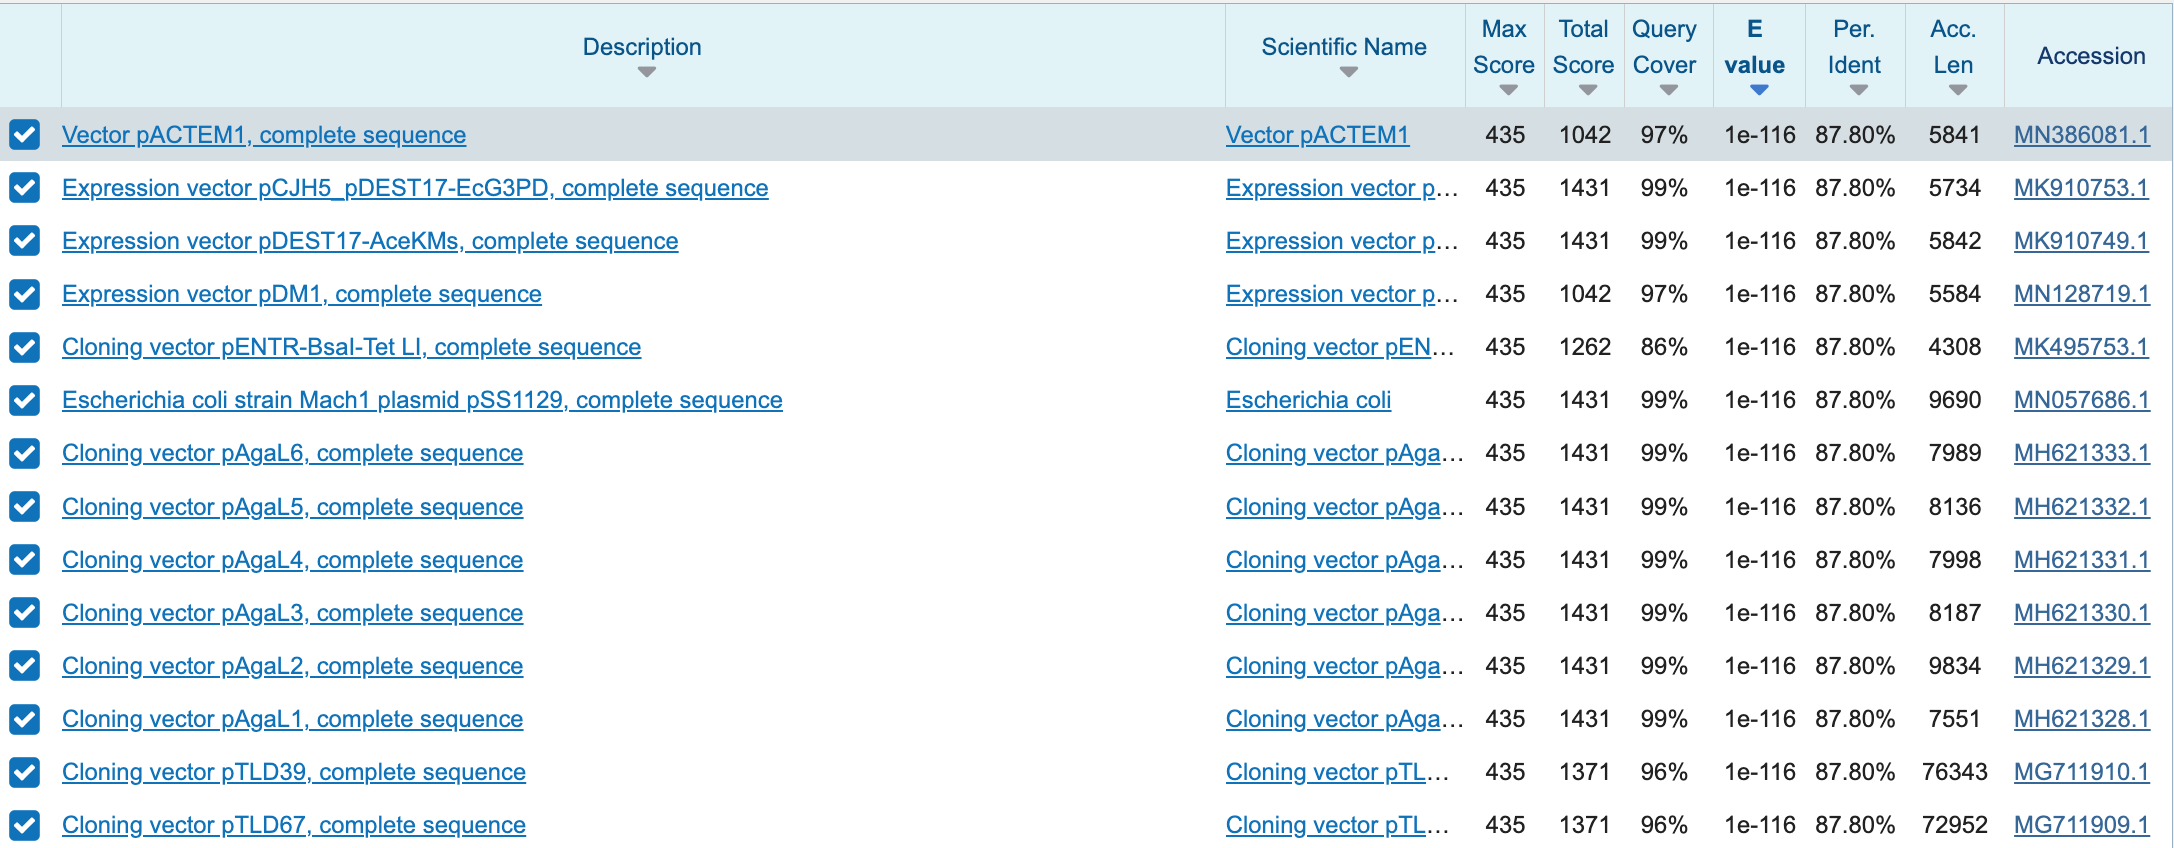

These results suggest that the most related DNA sequences belong to various vectors (highly unlikely), confirming that the DNA sequence given is ficticious.

## The same procedure can be done with the Dino_DNA_v2.fasta file

The DNA sequence from the Lost World novel can be investigated in the same way to see if this sequence is any more realistic than the previous sequence.

In [ ]:
dino_v2 = read_fasta("part2_Dino_DNA_v2.fasta")

display_sequences(dino_v2)

ORF 1:
Nucleotide sequence ATGGGAGCCATGGAGTTCGTGGCGCTGGGGGGGCCGGATGCGGGCTCCCCCACTCCGTTCCCTGATGAAGCCGGAGCCTTCCTGGGGCTGGGGGGGGGCGAGAGGACGGAGGCGGGGGGGCTGCTGGCCTCCTACCCCCCCTCAGGCCGCGTGTCCCTGGTGCCGTGGGCAGACACGGGTACTTTGGGGACCCCCCAGTGGGTGCCGCCCGCCACCCAAATGGAGCCCCCCCACTACCTGGAGCTGCTGCAACCCCCCCGGGGCAGCCCCCCCCATCCCTCCTCCGGGCCCCTACTGCCACTCAGCAGCGGGCCCCCACCCTGCGAGGCCCGTGAGTGCGTCATGGCCAGGAAGAACTGCGGAGCGACGGCAACGCCGCTGTGGCGCCGGGACGGCACCGGGCATTACCTGTGCAACTGGGCCTCAGCCTGCGGGCTCTACCACCGCCTCAACGGCCAGAACCGCCCGCTCATCCGCCCCAAAAAGCGCCTGCGGGTGAGTAAGCGCGCAGGCACAGTGTGCAGCCACGAGCGTGAAAACTGCCAGACATCCACCACCACTCTGTGGCGTCGCAGCCCCATGGGGGACCCCGTCTGCAACAACATTCACGCCTGCGGCCTCTACTACAAACTGCACCAAGTGAACCGCCCCCTCACGATGCGCAAAGACGGAATCCAAACCCGAAACCGCAAAGTTTCCTCCAAGGGTAAAAAGCGGCGCCCCCCGGGGGGGGGAAACCCCTCCGCCACCGCGGGAGGGGGCGCTCCTATGGGGGGAGGGGGGGACCCCTCTATGCCCCCCCCGCCGCCCCCCCCGGCCGCCGCCCCCCCTCAAAGCGACGCTCTGTACGCTCTCGGCCCCGTGGTCCTTTCGGGCCATTTTCTGCCCTTTGGAAACTCCGGAGGGTTTTTTGGGGGGGGGGCGGGGGGTTACACGGCCCCCCCGGGGCTGAGCCCGCAGATT
Nucleotid

Already this looks more promising as some of the detected ORFs are much longer than those found using the sequence from the Jurassic Park novel. We can run the longest ORF through the BLAST algorithm.

In [ ]:
dino_v2_aa = get_longest(find_ORF(dino_v2))

write_fasta(">Dinosaur_DNA_v2", dino_v2_aa, "Dino_amino_acids_v2.fasta")

Running this file through the BLAST algorithm gives the following results.

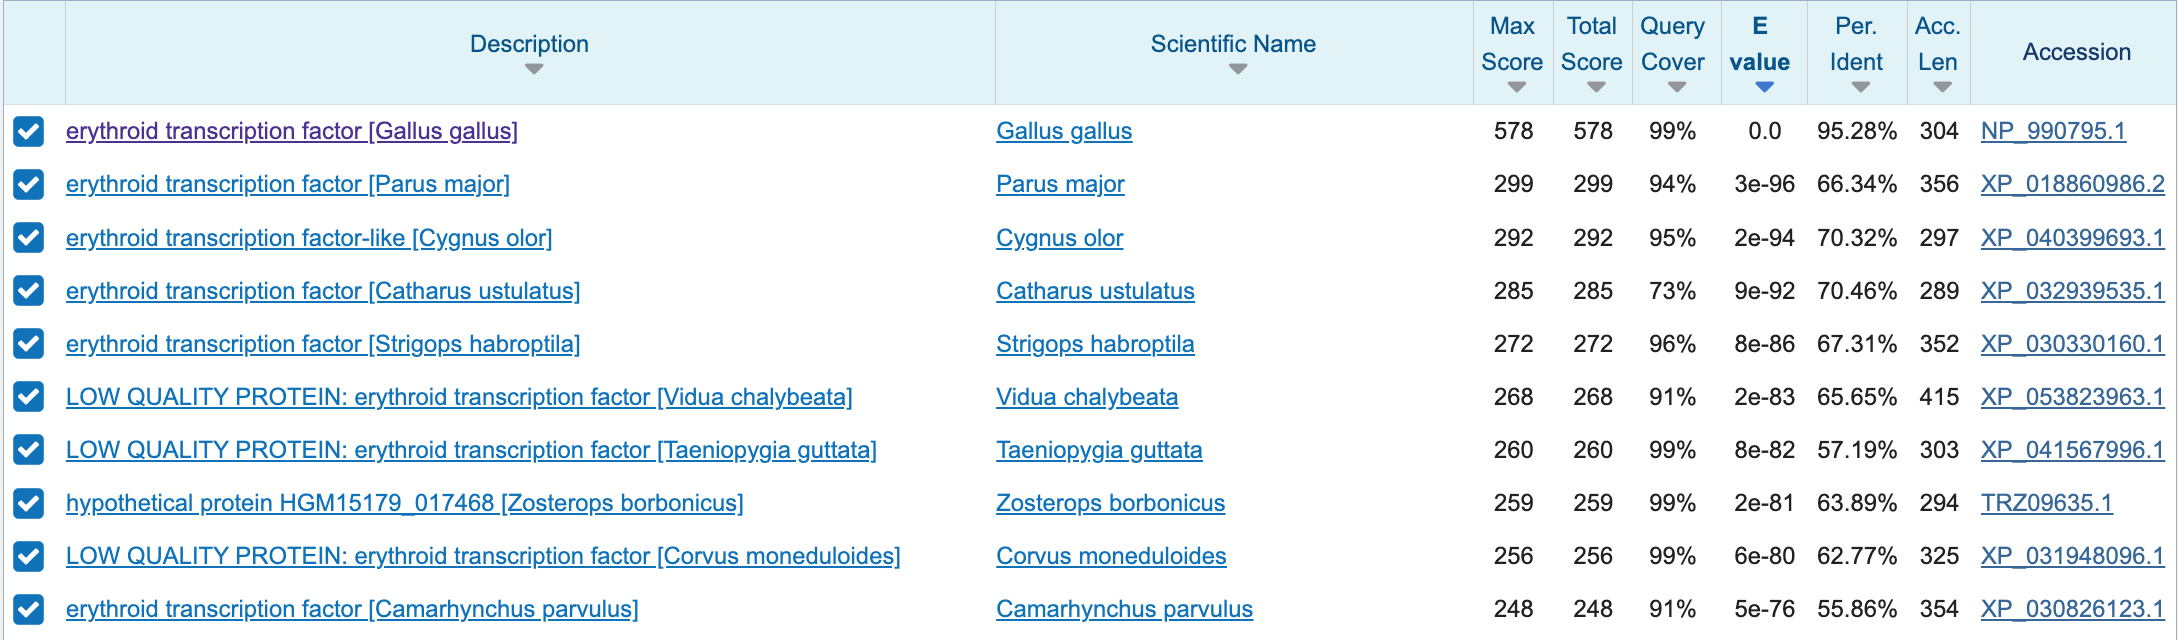

This suggests that the most related protein sequence belongs to a transcription factor found in Gallus gallus (chicken). This seems like a far more likely results, given that chicken are known to be closely related to dinosaurs.

The DNA sequence can also be ran through the BLAST algorithm.

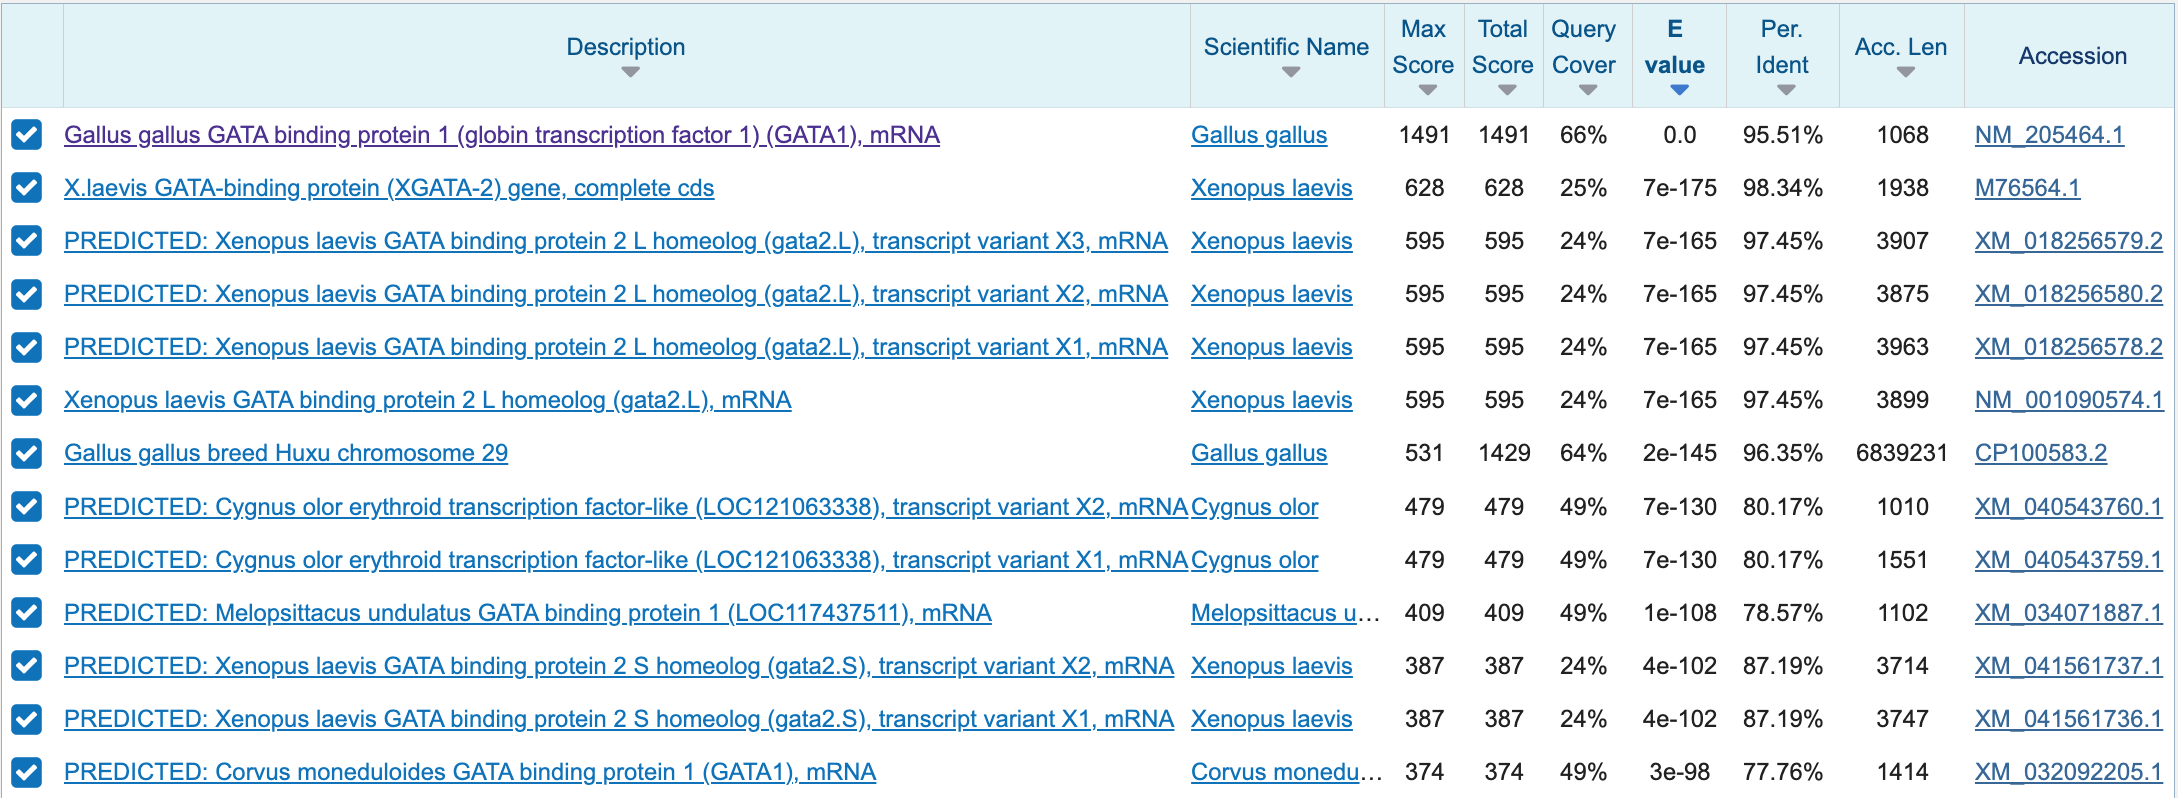

When the DNA sequence is ran through the BLAST algorithm, the most related sequence also appears to be from a transcription factor found in Gallus gallus, with a percent identity of 95.51%. This strongly indicates that the DNA sequence used in the Lost World novel is not ficticious, and in fact taken (with modification accounting, or the percent identity would be 100%) from the DNA of chicken.

# Part 3

The following sequence is given:

*>detected_olfactory_protein*
MEKRNLTVVREFVLLGLPSSAEQQHLLSVLFLCMYLATTLGNMLIIATIGFDSHLHSPMYFFLSNLAFVDICFTSTTVPQMVVNILTGTKTISFAGCLTQLFFFVSFVNMDSLLLCVMAYDRYVAICHPLHYTARMNLCLCVQLVAGLWLVTYLHALLHTVLIAQLSFCASNIIHHFFCDLNPLLQLSCSDVSFNVMIIFAVGGLLALTPLVCILVSYGLIFSTVLKITSTQGKQRAVST
CSCHLSVVVLFYGTAIAVYFSPSSPHMPESDTLSTIMYSMVAPMLNPFIYTLRNRDMKRGLQKMLLKCTVFQQQ

This can be saved into a fasta file as shown below.

In [ ]:
s = "MEKRNLTVVREFVLLGLPSSAEQQHLLSVLFLCMYLATTLGNMLIIATIGFDSHLHSPMYFFLSNLAFVDICFTSTTVPQMVVNILTGTKTISFAGCLTQLFFFVSFVNMDSLLLCVMAYDRYVAICHPLHYTARMNLCLCVQLVAGLWLVTYLHALLHTVLIAQLSFCASNIIHHFFCDLNPLLQLSCSDVSFNVMIIFAVGGLLALTPLVCILVSYGLIFSTVLKITSTQGKQRAVSTCSCHLSVVVLFYGTAIAVYFSPSSPHMPESDTLSTIMYSMVAPMLNPFIYTLRNRDMKRGLQKMLLKCTVFQQQ"

write_fasta(">detected_olfactory_protein", s, "detected_olfactory_protein.fasta")

All human peptide sequences can then be downloaded from ensembl, and the 'Homo_sapiens.GRCh38.pep.all.fa.gz' file can be expanded using the 'gunzip' command, to get a FASTA file containing the protein sequences, 'Homo_sapiens.GRCh38.pep.all.fa'.



A BLAST database is then made with the 'makeblastdb' command, as shown below:



> $ makeblastdb -in Homo_sapiens.GRCh38.pep.all.fasta -dbtype prot



This database can then be used to query sequences. This is done for the detected olfactory protein seqeunce.

> $ blastp -query detected_olfactory_protein.fasta -db Homo_sapiens.GRCh38.pep.all.fasta -out detected_olfactory_blast.txt -outfmt "7 qacc sacc qlen slen pident ppos length qstart qend sstart send evalue"



This creates a text file 'detected_olfactory_blast.txt' which contains a list of proteins (given by their protein IDs) and a number of calculated measurements that describe their alignment. The most significant measurement for this purpose is the E-value.

We will then use Python code to filter through this output file and get the sequences of the proteins that best align with out BLAST database.

In [ ]:
import pandas as pd

txt_file = open("detected_olfactory_blast.txt")
seq = [line.rstrip().split("\t") for line in txt_file][5:] # formating the text file into a list of lists so that we can use indexing to extract relevant data

seq = seq[:-1] # remove last line as it causes indexing problem (and contains no useful information)

# create dictionary with protein IDs and corresponding data
seq_dict = {"Protein ID": [entry[1] for entry in seq], "% Positives": [float(entry[5]) for entry in seq], "Length": [int(entry[3]) for entry in seq], "E-value": [float(entry[11]) for entry in seq]}

# make pandas dataframe
df = pd.DataFrame(seq_dict)
display(df)


,Protein ID,% Positives,Length,E-value
0,ENSP00000386138.2,100.00,314,0.000000e+00
1,ENSP00000493457.1,100.00,314,0.000000e+00
2,ENSP00000305424.2,76.07,312,4.060000e-129
3,ENSP00000343521.1,72.20,313,9.260000e-114
4,ENSP00000331545.2,72.79,313,2.340000e-113
...,...,...,...,...
496,ENSP00000364164.1,62.22,311,2.930000e-74
497,ENSP00000321338.3,62.50,326,4.500000e-74
498,ENSP00000492951.1,59.93,316,4.770000e-74
499,ENSP00000314324.2,61.84,319,4.840000e-74


Then filter for hits with an E-value <= 1e-30, % Positives >= 60%, and length >= 290 amino acids.

In [ ]:
df_filtered = df[(df["% Positives"] >= 60) & (df["E-value"] <= 1*10**(-30)) & (df["Length"] > 290)]
df_filtered = df_filtered.sort_values("% Positives", ascending=False, ignore_index=True) # sort by E-value
display(df_filtered)

,Protein ID,% Positives,Length,E-value
0,ENSP00000386138.2,100.00,314,0.000000e+00
1,ENSP00000493457.1,100.00,314,0.000000e+00
2,ENSP00000305424.2,76.07,312,4.060000e-129
3,ENSP00000331545.2,72.79,313,2.340000e-113
4,ENSP00000343521.1,72.20,313,9.260000e-114
...,...,...,...,...
455,ENSP00000492961.1,60.07,311,2.540000e-74
456,ENSP00000400546.1,60.07,311,7.990000e-75
457,ENSP00000388205.1,60.07,311,7.990000e-75
458,ENSP00000388392.1,60.07,311,7.990000e-75


The top 200 proteins will be used for build an HMM profile.

In [ ]:
df_top_200 = df_filtered[0:200] # get IDs of top 200 sequences
display(df_top_200)

,Protein ID,% Positives,Length,E-value
0,ENSP00000386138.2,100.00,314,0.000000e+00
1,ENSP00000493457.1,100.00,314,0.000000e+00
2,ENSP00000305424.2,76.07,312,4.060000e-129
3,ENSP00000331545.2,72.79,313,2.340000e-113
4,ENSP00000343521.1,72.20,313,9.260000e-114
...,...,...,...,...
195,ENSP00000449350.1,63.25,316,3.100000e-78
196,ENSP00000380023.3,63.25,316,3.100000e-78
197,ENSP00000447580.1,63.25,316,3.100000e-78
198,ENSP00000447204.1,63.25,316,3.100000e-78


## Saving top 200 sequences into a FASTA file

We now have the protein IDs of the 200 protein sequences that are most similar to the sequence of the detected olfactory protein. We must now go through the 'Homo_sapiens.GRCh38.pep.all.fasta' file and obtain the protein sequences corresponding to the each protein ID.

In [ ]:
# read Homo_sapiens.GRCh38.pep.all.fasta and created dictionary containing protein IDs and their corresponding amino acid sequences
sequences = SeqIO.parse("Homo_sapiens.GRCh38.pep.all.fasta", "fasta")

protein_dict = {"Protein ID": [], "Seq": []} # get dictionary containing IDs and sequences for each protein in the file
for record in sequences:
  protein_dict["Protein ID"].append(record.name)
  protein_dict["Seq"].append(record.seq)

names = df_top_200["Protein ID"].tolist() # get list of protein IDs that are in the dataframe shown above


In [ ]:
with open("olfactory_blast_protein_sequences.fasta", 'w') as handle: # write a new FASTA file
  for ID in protein_dict["Protein ID"]:
    if ID in names:
      ind = protein_dict["Protein ID"].index(ID)
      seq = str(protein_dict["Seq"][ind])
      handle.write(">" + ID + "\n" + seq + "\n\n")

This gives us a FASTA file containing the IDs and sequences of the 200 human proteins whose sequences are most similar to that of the detected olfactory protein.

## Using Jalview to interpret results

This FASTA file can be loaded into Jalview. Clustal Omega is then used (via Jalview) to carry out multiple sequence alignment.

Some sequences appear to be too long and/or contain long insertions. These should be removed from the alignment. An example is shown below of a sequence that should be removed.

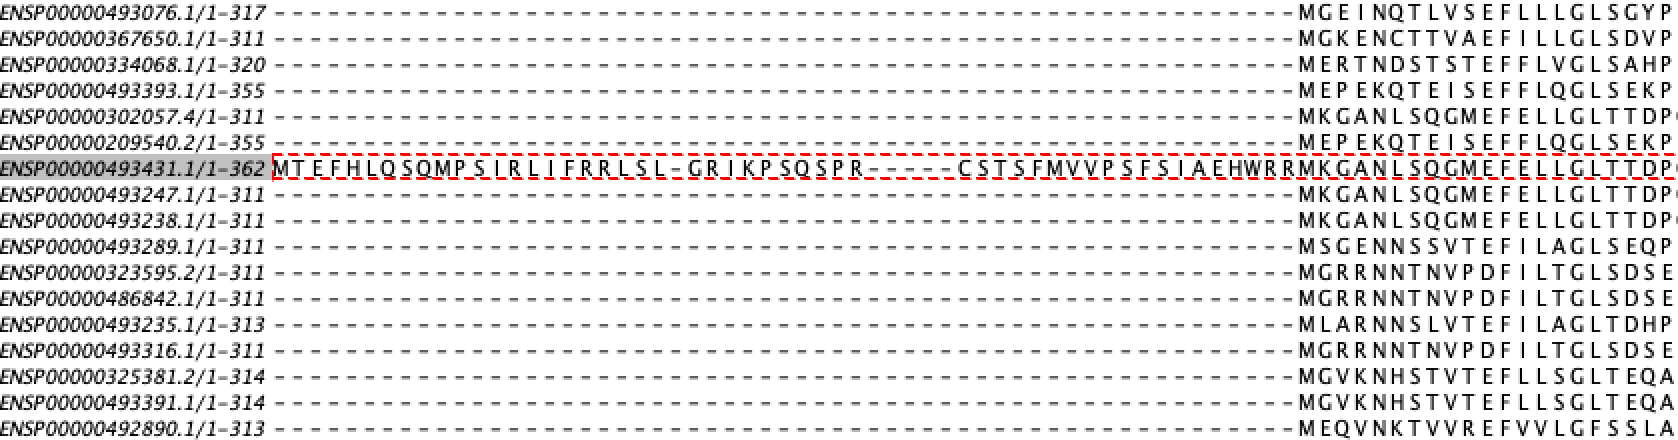

Jalview can then be used to create a phylogenetic tree (Neighbour joining method) from the cleaned multiple sequence alignment (MSA).

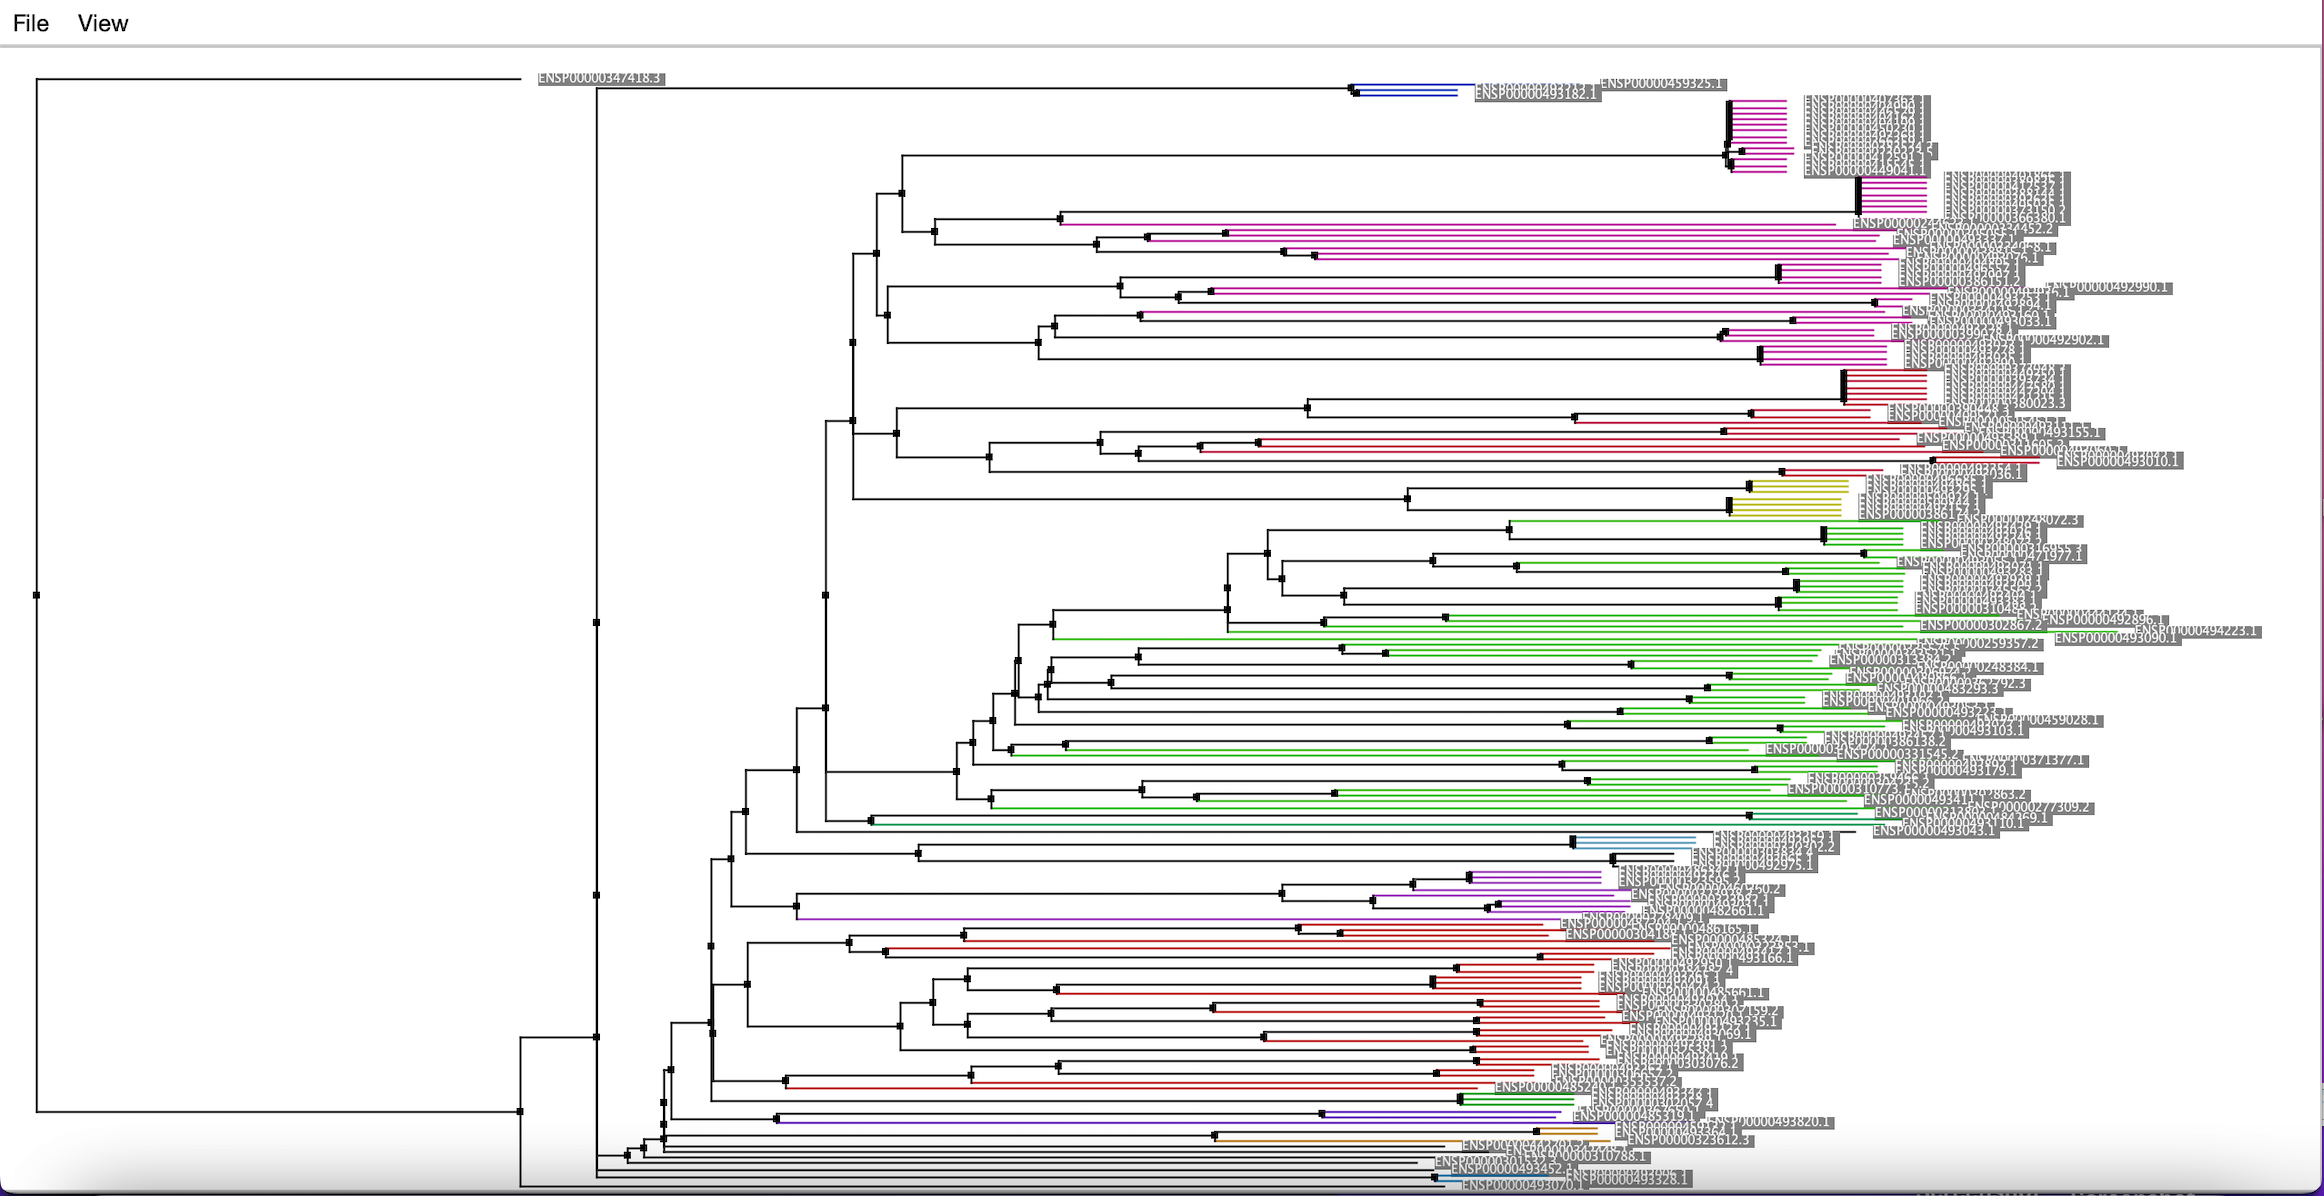

This phylogenetic tree suggests that there are roughly 13 main subgroups of human olfactory receptors (shown by different colours). In reality, the human olfactory receptor gene superfamily can be divided into 18 gene families, suggesting that a more detailed analysis is required to form an accurate phylogenetic tree.

Going back into Ensembl, this phylogenetic tree can be investigated to see if the MSA has been successful. The following sequences were taken from the top branch of this tree (highlighted blue), and both correspond to genes in the OR9G4 subgroup.


*   ENSP00000493182.1 - OR9G4-203
*   ENSP00000493212.1 - OR9G4-202

Similarly, the following sequences from the next cluster of 'leaves' on the phylogenetic tree (highlighted magenta) and all correspond to genes in the OR5V1 subgroup.


*   ENSP00000446579.1 - OR5V1-214
*   ENSP00000404990.1 - OR5V1-213
*   ENSP00000407363.1 - OR5V1-212

This suggests that the MSA was succesful and the phylogenetic tree (somewhat) accurately represents how related different sequences (and their corresponding genes) are.





By colouring the alignment (using Zappo in this case), different subgroups of olfactory genes can be identified. An example of a closely related subgroup is shown below.

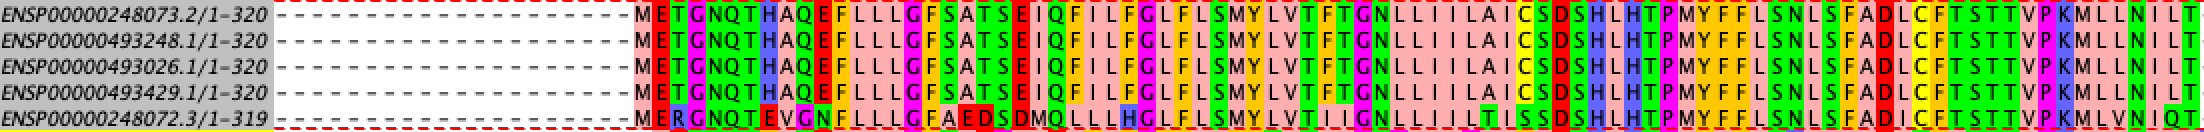

The sequence at the bottom of this section clearly shows the most sequence variation in this subgroup. This is highlighted by the different colour pattern.

Regions that are highly conserved can also be found in the MSA. Colouring the amino acids by BLOSUM62 score allows the most highly conserved regions to be identified. An example of this is shown below with the highly conserved region selected (outlined by dashed red line).

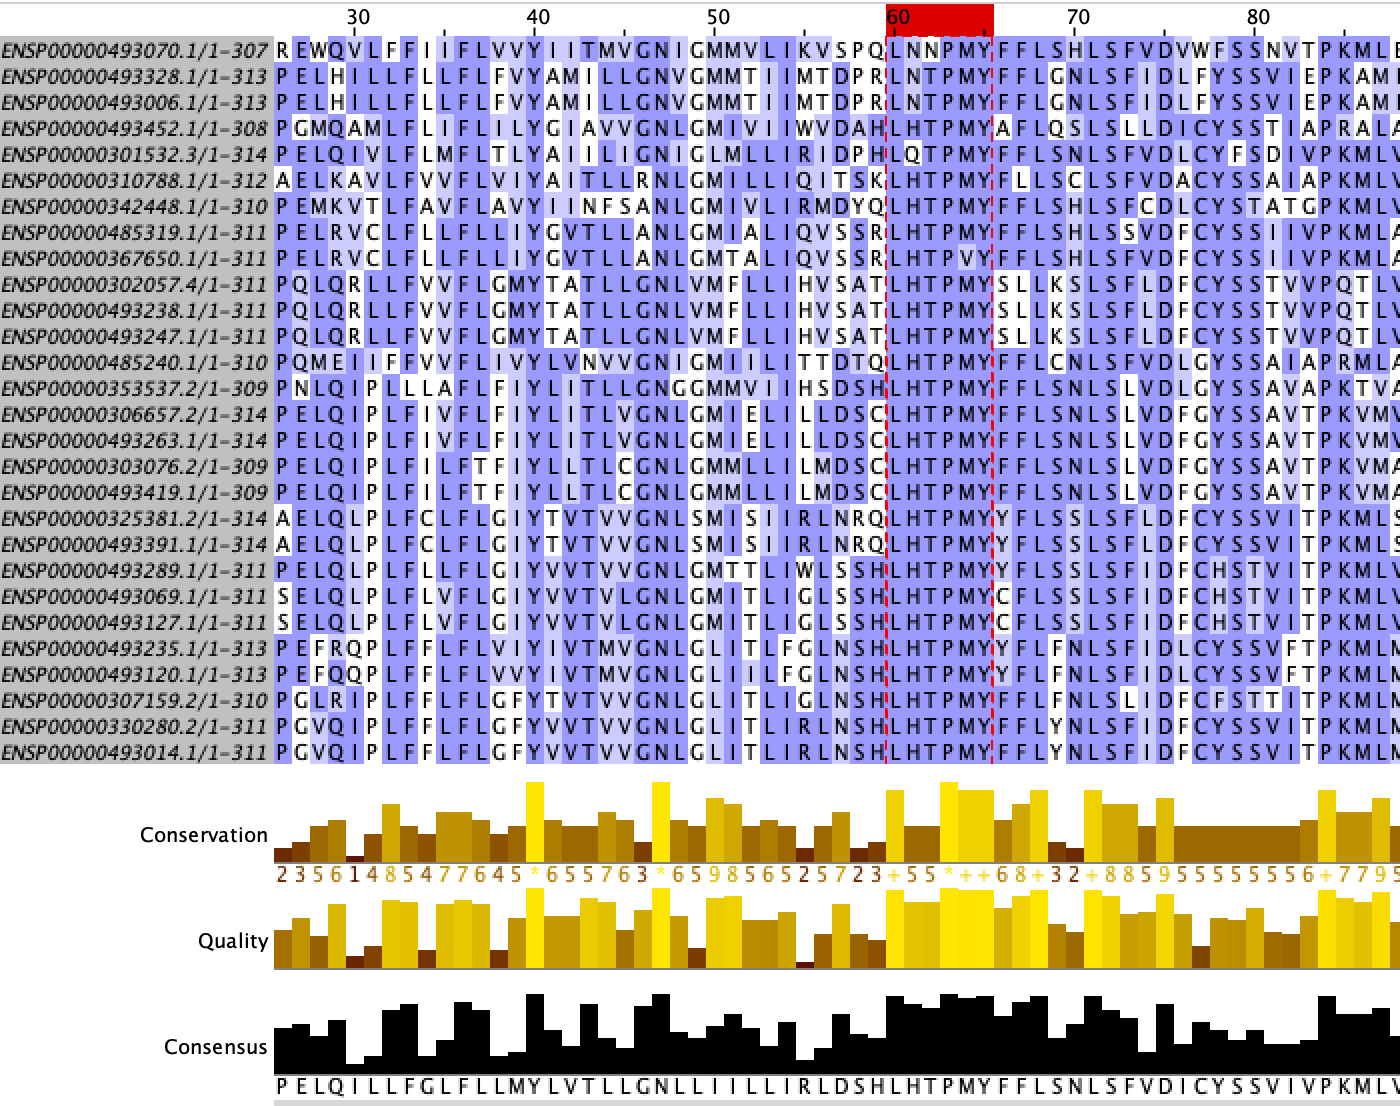

The 'Conservation', 'Quality', and 'Consensus' tools that can be seen at the bottom also indicate that this region is highly conserved, with peaks in all three of these measures.

Highly conserved regions in the protein sequence are likely to correspond to the part of the protein that is most important for its function. In the case of olfactory receptors, the transmembrane domain is likely to be conserved between different receptors as they are all likely to be bound to cell membranes in a similar way.

In contrast to this binding sites of these receptors are likely to be similar within subgroups of olfactory receptors, however for two more distantly related olfactory receptors, there binding sites are likely to be fairly different, as they bind to different types of molecules.

## Building HMM model

An HMM profile of the aligned sequences can be generated using HMMer. The alignment in Jalview was first saved into a stockholm file titled 'olfactory_aligment.sto'. The 'hmmbuild' command was then used in terminal to generate an HMM profile based on this alignment.



> $ hmmbuild olfactory.hmm olfactory_alignment.sto

This creates an HMM profile which is saved into the file 'olfactory.hmm'. The 'hmmsearch' command can then be used to compare protein sequences against the HMM profile.

Protein sequences from a variety of mammals can be downloaded from Ensemble as a FASTA file. For example, mouse (Mus musculus) proteins, saved into a file titled 'Mus_musculus.GRCm39.pep.all.fa'. This set of sequences can be compared to the HMM profile using the command shown below.


> $ hmmsearch olfactory.hmm Mus_musculus.GRCm39.pep.all.fa > mouse.out

This compares the sequences in 'Mus_musculus.GRCm39.pep.all.fa' to the HMM profile in 'olfactory.hmm' and saves the output to a file titled 'mouse.out'. The output file can then be explored using Python code.








In [ ]:
def display_results(file_name, filtered=True):
  tmp = open(file_name)
  file_out = [line.rstrip().split("\t")[0].split() for line in tmp]
  # index 14 to 3187 (including 3187) contain the data, other data entries are not in inclusion threshhold

  n = file_out.index(['------', 'inclusion', 'threshold', '------'])

  out_data = {
      "E-value (fs)": [float(entry[0]) for entry in file_out[14:n]],
      "Score (fs)": [float(entry[1]) for entry in file_out[14:n]],
      "Bias (fs)": [float(entry[2]) for entry in file_out[14:n]],
      "E-value (best)": [float(entry[3]) for entry in file_out[14:n]],
      "Score (best)": [float(entry[4]) for entry in file_out[14:n]],
      "Bias (best)": [float(entry[5]) for entry in file_out[14:n]],
      "Exp": [float(entry[6]) for entry in file_out[14:n]],
      "N": [int(entry[7]) for entry in file_out[14:n]],
      "Sequence": [entry[8] for entry in file_out[14:n]],
      "Description": [entry[9] for entry in file_out[14:n]]
      }

  out_df = pd.DataFrame(out_data)

  if filtered:
    out_filtered_df = out_df[out_df["E-value (fs)"] <= 1*10**(-30)] # apply filter using E-values
    display(out_filtered_df)
  else:
    display(out_df)

In [ ]:
display_results("mouse.out")

,E-value (fs),Score (fs),Bias (fs),E-value (best),Score (best),Bias (best),Exp,N,Sequence,Description
0,1.500000e-141,473.0,22.8,1.700000e-141,472.9,22.8,1.0,1,ENSMUSP00000058242.5,pep
1,1.500000e-141,473.0,22.8,1.700000e-141,472.9,22.8,1.0,1,ENSMUSP00000150285.3,pep
2,4.000000e-141,471.6,21.3,4.400000e-141,471.5,21.3,1.0,1,ENSMUSP00000088524.2,pep
3,4.000000e-141,471.6,21.3,4.400000e-141,471.5,21.3,1.0,1,ENSMUSP00000150608.2,pep
4,3.600000e-140,468.5,21.5,4.000000e-140,468.3,21.5,1.0,1,ENSMUSP00000064189.3,pep
...,...,...,...,...,...,...,...,...,...,...
2765,8.800000e-34,119.0,1.6,9.800000e-34,118.9,1.6,1.0,1,ENSMUSP00000151413.2,pep
2766,7.900000e-33,115.9,7.2,8.500000e-33,115.8,7.2,1.0,1,ENSMUSP00000121666.3,pep
2767,1.900000e-32,114.6,4.5,2.100000e-32,114.5,4.5,1.0,1,ENSMUSP00000146402.2,pep
2768,4.700000e-32,113.4,4.3,5.000000e-32,113.3,4.3,1.0,1,ENSMUSP00000133824.3,pep


This suggests that there are 2770 olfactory receptor proteins in mice.

This process can be repeated for other mammalian species, such as dogs (Canus lupus familiaris):

In [ ]:
display_results("dog.out")

,E-value (fs),Score (fs),Bias (fs),E-value (best),Score (best),Bias (best),Exp,N,Sequence,Description
0,1.100000e-143,479.4,24.5,1.300000e-143,479.2,24.5,1.0,1,ENSCAFP00845008111.1,pep
1,3.800000e-141,471.1,22.6,4.300000e-141,470.9,22.6,1.0,1,ENSCAFP00845008073.1,pep
2,2.400000e-140,468.4,13.6,2.700000e-140,468.3,13.6,1.0,1,ENSCAFP00845042547.1,pep
3,3.500000e-140,467.9,20.3,3.800000e-140,467.8,20.3,1.0,1,ENSCAFP00845033558.1,pep
4,8.400000e-140,466.7,13.6,9.800000e-140,466.5,13.6,1.0,1,ENSCAFP00845042536.1,pep
...,...,...,...,...,...,...,...,...,...,...
739,3.800000e-50,172.2,21.0,4.400000e-50,171.9,21.0,1.0,1,ENSCAFP00845026477.1,pep
740,3.200000e-45,156.0,11.8,3.500000e-45,155.9,11.8,1.0,1,ENSCAFP00845043457.1,pep
741,1.300000e-37,130.9,1.1,1.500000e-37,130.8,1.1,1.0,1,ENSCAFP00845029134.1,pep
742,1.200000e-32,114.7,23.5,4.000000e-32,113.0,23.5,1.8,1,ENSCAFP00845027527.1,pep


This suggests that dogs have 744 olfactory receptor proteins.

Cats (Felis catus):

In [ ]:
display_results("cat.out")

,E-value (fs),Score (fs),Bias (fs),E-value (best),Score (best),Bias (best),Exp,N,Sequence,Description
0,6.100000e-165,549.2,51.5,1.900000e-98,330.7,27.2,2.0,2,ENSFCAP00000013684.3,pep
1,1.700000e-141,472.1,21.0,1.900000e-141,471.9,21.0,1.0,1,ENSFCAP00000030720.1,pep
2,3.800000e-141,471.0,18.9,4.200000e-141,470.8,18.9,1.0,1,ENSFCAP00000055042.1,pep
3,1.700000e-140,468.8,20.5,1.900000e-140,468.7,20.5,1.0,1,ENSFCAP00000022682.2,pep
4,2.800000e-140,468.2,19.9,3.000000e-140,468.0,19.9,1.0,1,ENSFCAP00000048443.1,pep
...,...,...,...,...,...,...,...,...,...,...
686,6.000000e-53,181.2,11.7,7.500000e-53,180.9,11.7,1.0,1,ENSFCAP00000028041.2,pep
687,4.600000e-48,165.2,11.9,9.800000e-36,124.7,9.0,2.0,2,ENSFCAP00000033233.1,pep
688,1.700000e-36,127.2,12.4,1.100000e-23,85.1,3.6,2.0,2,ENSFCAP00000026984.2,pep
689,8.000000e-36,125.0,0.6,9.900000e-36,124.7,0.6,1.0,1,ENSFCAP00000041275.1,pep


This suggests that we cats have 691 olfactory receptor genes.

Chimpanzees (Pan troglodytes):

In [ ]:
display_results("chimp.out")

,E-value (fs),Score (fs),Bias (fs),E-value (best),Score (best),Bias (best),Exp,N,Sequence,Description
0,9.700000e-140,466.7,20.0,1.200000e-139,466.4,20.0,1.0,1,ENSPTRP00000030502.4,pep
1,8.600000e-139,463.6,23.0,9.800000e-139,463.4,23.0,1.0,1,ENSPTRP00000006298.3,pep
2,1.600000e-137,459.4,26.6,1.800000e-137,459.2,26.6,1.0,1,ENSPTRP00000006281.5,pep
3,3.100000e-137,458.5,19.4,3.400000e-137,458.3,19.4,1.0,1,ENSPTRP00000060726.1,pep
4,4.500000e-137,457.9,23.3,5.400000e-137,457.6,23.3,1.0,1,ENSPTRP00000018093.3,pep
...,...,...,...,...,...,...,...,...,...,...
347,4.500000e-53,182.0,12.0,5.000000e-53,181.8,12.0,1.0,1,ENSPTRP00000089144.1,pep
348,8.800000e-51,174.4,11.3,1.500000e-48,167.2,10.2,2.0,2,ENSPTRP00000069025.1,pep
349,3.200000e-46,159.5,23.3,4.500000e-46,159.0,23.3,1.1,1,ENSPTRP00000069779.1,pep
350,1.600000e-38,134.2,16.2,2.400000e-38,133.6,16.2,1.2,1,ENSPTRP00000063654.1,pep


Suggesting chimps possess only 352 olfactory receptor proteins.

Elephants (Loxodonta africana):

In [ ]:
display_results("elephant.out")

,E-value (fs),Score (fs),Bias (fs),E-value (best),Score (best),Bias (best),Exp,N,Sequence,Description
0,6.400000e-141,469.6,18.3,7.000000e-141,469.5,18.3,1.0,1,ENSLAFP00000024512.1,pep
1,1.100000e-140,468.8,21.8,1.200000e-140,468.6,21.8,1.0,1,ENSLAFP00000024514.1,pep
2,4.900000e-140,466.7,22.8,5.400000e-140,466.5,22.8,1.0,1,ENSLAFP00000027508.1,pep
3,1.500000e-139,465.1,23.5,1.800000e-139,464.8,23.5,1.0,1,ENSLAFP00000025766.1,pep
4,1.900000e-139,464.8,20.8,2.100000e-139,464.6,20.8,1.0,1,ENSLAFP00000023407.1,pep
...,...,...,...,...,...,...,...,...,...,...
1952,1.600000e-39,136.5,25.6,1.900000e-39,136.3,25.6,1.1,1,ENSLAFP00000027595.1,pep
1953,3.000000e-39,135.6,10.7,3.300000e-39,135.5,10.7,1.0,1,ENSLAFP00000019014.1,pep
1954,2.700000e-38,132.5,6.7,3.100000e-38,132.3,6.7,1.0,1,ENSLAFP00000025968.1,pep
1955,1.500000e-36,126.8,15.1,1.600000e-36,126.6,15.1,1.0,1,ENSLAFP00000028668.1,pep


Suggesting that elephants possess 1957 olfactory receptor proteins.

These results can be displayed graphically as shown below. These values are similar to those stated in the literature, suggesting that this method yields reasonable results.

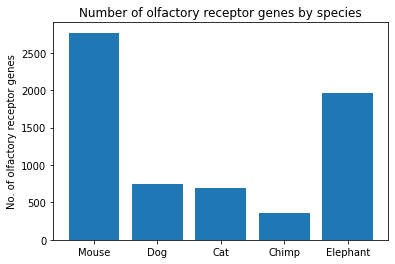

In [ ]:
import matplotlib.pyplot as plt


plt.bar([1, 2, 3, 4, 5], [2770, 744, 691, 352, 1957], tick_label=["Mouse", "Dog", "Cat", "Chimp", "Elephant"])
plt.title("Number of olfactory receptor genes by species")
plt.ylabel("No. of olfactory receptor genes")
plt.show()

# Assumptions and limitations

In carrying out this multiple sequence alignment and using it to detect olfactory receptors in the proteome of different mammals, we have made some key assumptions.

1.   The original 'detected olfactory protein' sequence was correctly derived and is closely related to all other human olfactory receptor proteins
2.   All olfactory protein sequences are significantly related to one another. This may not always be the case for olfactory receptors that bind to very different molecules, and may belong to very different species.
3.   The set of human olfactory receptors is representative of those found in other species. For example, if a particular family of olfactory receptors is abundant in humans but not in dogs, our MSA is likely to contain some bias towards recognising this family of receptors, and so may not detect the full range of receptors that are present in dogs.

For the purpose of this investigation, these assumptions are acceptable as we would expect a relatively high degree of conservation between mammalian olfactory receptor genes.

The method carried out in this investigation also has some inherent limitations.

1.   Due to how Ensembl annotates protein sequences, sometimes multiple sequences are included separately even though they originate from the same gene. This likely inflates the counts for species that are better annotated.
2.   Progressive sequence alignment (as Clustal Omega was used in this investigation) has some inherent limitations such as the 'once a gap always a gap' rule meaning that the algorithm can sometimes find local minima such that the complete alignment may not be globally optimal.

# Suggested improvements

1.   Multiple detected olfactory sequences (experimentally obtained) could be used initially to build an HMM profile to then detect olfactory proteins present in the human proteome, rather than relying on comparison with a single sequence.
2.   A larger number of sequences from the BLAST search can be used to build a better MSA, however this would be more computationally expensive.
3.   After downloading the protein sequences of a given species from Ensembl, an algorithm may be used to remove sequences that are very similar to another sequence in the file (the specific parameters would have to be found through running many tests). This would prevent the inflation of olfactory receptor gene counts for species that are better annotated in Ensembl.
4.   The class Mammalia could be divided into different Orders or even Families and these subgroups could be investigated separately with separate HMM profiles. This is so that the results of a given HMM search is less biased towards different groups of species.





